In [1]:
import pickle

with open('df1.pickle','rb') as read_file:
    df1 = pickle.load(read_file)

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import json
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore")

##  Linear Regression Assumption Testing

The regression has five key assumptions:

* Linear relationship
* Multivariate normality
* No or little multicollinearity
* No auto-correlation
* Homoscedasticity

#### Q-Q plot to test residual normality assumption

Text(0, 0.5, 'Ordered Values')

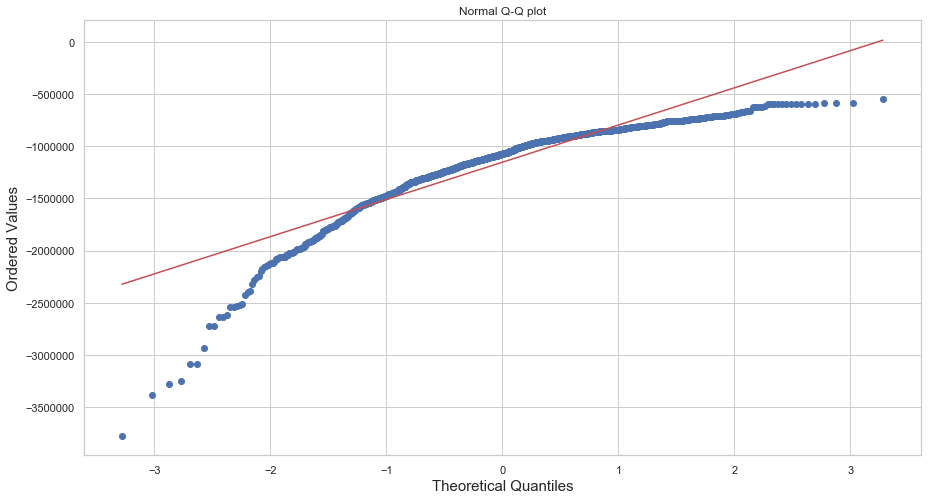

In [34]:
X = df1[['parking','# of beds','# of baths','sqft','Type_Apartment','Type_Condo','Type_Multi Family','Type_Single Family','City_SAN FRANCISCO','City_SAN MATEO','City_DALY CITY','City_PACIFICA']]

# 10 fold cross validation
y = df1['total_price_log']
# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

# simple linear regression
lm = LinearRegression()
lm.fit(X, y)
predictions = np.exp(lm.predict(X))

plt.figure(figsize=[15,8])
sns.set(style="whitegrid")
res = y - predictions
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.xlabel("Theoretical Quantiles",fontsize = 15)
plt.ylabel("Ordered Values",fontsize = 15)


#### Check for homoscedasticity

In [7]:
# try weighted least squares to handle heteroscedasticity

y = df1['total_price_log']
# X = df1[['parking_scaled','# of beds_scaled','# of baths_scaled','sqft_scaled','Type_Apartment','Type_Condo','Type_Multi Family','Type_Single Family','City_SAN FRANCISCO','City_SAN MATEO','City_DALY CITY','City_PACIFICA']]
X = df1[['parking','# of beds','# of baths','sqft','Type_Apartment','Type_Condo','Type_Multi Family','Type_Single Family','City_SAN FRANCISCO','City_SAN MATEO','City_DALY CITY','City_PACIFICA']]
X = sm.add_constant(X)

# the key question about weighted lease squares is to determine the weight, here i'm going to try different weights

# use weights that is inverse to X (reverse the weight to outliers)
w = np.array([1/x.mean() ** 2 for x in np.array(X_scaled)])
w.shape

/Users/zhaoze/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/zhaoze/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/zhaoze/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(1667,)

In [8]:
mod_wls = sm.WLS(y, X, weights=w)
res_wls = mod_wls.fit()
res_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        total_price_log   R-squared:                       0.767
Model:                            WLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     543.8
Date:                Tue, 23 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:58:44   Log-Likelihood:                -3175.0
No. Observations:                1667   AIC:                             6372.
Df Residuals:                    1656   BIC:                             6432.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.7480      0.166     52.776      0.000       8.423       9.073
parking               -0.0133      0.036     -0.370      0.711      -0.084       0.057
# of beds              0.1514      0.029      5.300      0.000       0.095       0.207
# of baths             0.0873      0.034      2.537      0.011       0.020       0.155
sqft                   0.0001   5.61e-05      2.041      0.041    4.45e-06       0.000
Type_Apartment         2.0950      0.570      3.673      0.000       0.976       3.214
Type_Condo             2.2501      0.180     12.514      0.000       1.897       2.603
Type_Multi Family      2.1176      0.172     12.344      0.000       1.781       2.454
Type_Single Family     2.2853      0.181     12.639      0.000       1.931       2.640
City_SAN FRANCISCO     2.3962      0.042     56.752      0.000       2.313       2.479
City_SAN MATEO         2.3634      0.043     55.288      0.000       2.280       2.447
City_DALY CITY         2.0992      0.042     49.539      0.000       2.016       2.182
City_PACIFICA          1.8891      0.043     44.270      0.000       1.805       1.973
==============================================================================
Omnibus:                     2477.176   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4698177.024
Skew:                          -8.056   Prob(JB):                         0.00
Kurtosis:                     262.578   Cond. No.                     1.11e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.17e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
# plot 
df1['predictions'] = res_wls.predict(X_scaled)

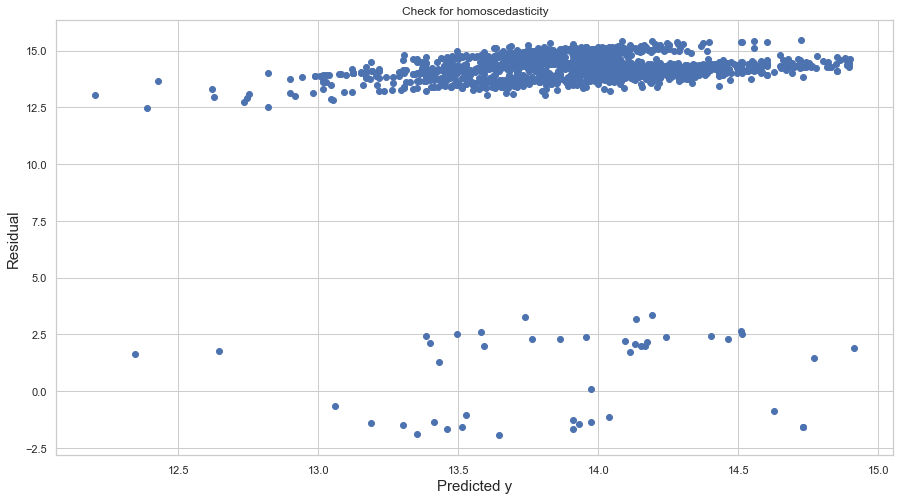

In [10]:
plt.figure(figsize=[15,8])
sns.set(style="whitegrid")
res = df1['total_price_log'] - df1['predictions']
plt.title("Check for homoscedasticity")
plt.xlabel("Predicted y",fontsize = 15)
plt.ylabel("Residual",fontsize = 15)
plt.scatter(df1['total_price_log'],res)
plt.show()

The plot above shows residuals are clearly downward sloping, indicate heteroscedasticity still exists.

#### Check for auto-correlation

(array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5]),
 array([0.97288413, 0.97327581, 0.9735225 , 0.97796482, 0.97522181,
        1.        , 0.97522181, 0.97796482, 0.9735225 , 0.97327581,
        0.97288413]),
 <matplotlib.lines.Line2D at 0x1c23035470>)

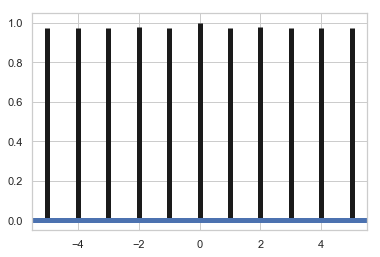

In [11]:
# plot, maxlags indicate maximum lags to show
plt.acorr(res, usevlines=True, normed=True, maxlags=5, lw=5)

In [12]:
# DW
from statsmodels.stats.stattools import durbin_watson

durbin_watson(res)

0.04836077370998333

**Conclusion:** From DW test results and the plot above, we know that there's not auto-correlation in residuals. 

#### Check for multicollinearity

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

/Users/zhaoze/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/zhaoze/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [14]:
vif.round(1)

,VIF Factor,features
0,0.0,const
1,1.2,parking
2,2.6,# of beds
3,2.7,# of baths
4,2.8,sqft
5,inf,Type_Apartment
6,inf,Type_Condo
7,inf,Type_Multi Family
8,inf,Type_Single Family
9,inf,City_SAN FRANCISCO


**Inspect VIF Factors:**
As expected, the parking, # of beds/baths and sqft have no collinearity. 

## Final Model Out-of-Sample Performance:

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = np.sqrt(mean_squared_error(y_test, lm.predict(X_test)))

In [37]:
mse

0.24297022083393555

The MSE results on test data indicates the model has similar performance on the training data (MSE 0.23).